<a href="https://colab.research.google.com/github/TangJiahui/6.036_Machine_Learning/blob/main/MIT_6_036_HW11_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN for Name Generation

In the following problem, we will look at using an RNN to generate names in different languages. Much of the code is below is given to you, as our goal is more to expose you to more PyTorch code which you'd likely see in practical ML implementations than expecting you to code PyTorch proficiently for this class.

In [1]:
!rm -rf code_for_hw11* __MACOSX data .DS_Store
!wget --no-check-certificate --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw11/char_rnn_data.zip
!unzip char_rnn_data.zip

!wget --no-check-certificate --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw11/char_rnn_utils.zip
!unzip char_rnn_utils.zip

from char_rnn_utils import timeSince, all_letters, n_letters, get_data, categoryTensor, inputTensor, randomTrainingExample

import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

Archive:  char_rnn_data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  
Archive:  char_rnn_utils.zip
  inflating: char_rnn_utils.py       


In [2]:
# all_letters contains all possible letters in names
print('All letters:', all_letters)
# number of letters + 1 for the end-of-string (EOS) token
print('Number of letters and EOS token:', n_letters)
# categoryTensor, inputTensor convert categories and letters (not including EOS) to one-hot vectors

All letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-
Number of letters and EOS token: 59


In [3]:
# Get the data
all_categories, category_lines = get_data()
n_categories = len(all_categories)

In [29]:
n_categories

18

In [30]:
n_letters

59

## Model

Below, we define the RNN architecture that we'll be exploring. The RNN we use will take in the previous character and hidden state to calculate the new hidden state and predict the next character in the string. This architecture is a bit different from the basic version we've discussed: while the RNN maintains a hidden state, it will also compute a second `output` vector of the output size via the `input2output` fully-connected layer and then concatenate it with the hidden vector and use another fully-connected layer to get the actual prediction. We've written most of the details of the model, but we would like you figure out the dimensions for each of the fully-connected layers. Also, the RNN combines its three inputs into one vector by concatenation before passing it through its fully-connected layers `input2hidden` and `input2output`.

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Replace d1-4 with expressions in terms of the variables 
        # n_categories, input_size, hidden_size, and output_size
        d1 = input_size + hidden_size + n_categories
        d2 = hidden_size            
        d3 = output_size            
        d4 = output_size+hidden_size 

        self.input2hidden = nn.Linear(d1, d2)
        self.input2output = nn.Linear(d1, d3)
        self.output2output = nn.Linear(d4, d3)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    # Runs the forward pass of the model with the given inputs
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.input2hidden(input_combined)
        output = self.input2output(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.output2output(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Now let's train the model! This will take a bit of time (about 30 seconds when we ran it).

In [41]:
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor, learning_rate):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # oftentimes, we'll use other optimizers like Adam, but we'll keep it simple
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [42]:
# The following two lines are very important so that you ge tthe right results!
random.seed(0)
torch.manual_seed(0)

rnn = RNN(n_letters, 128, n_letters)

# Keep these parameters for your homework submission,
# but feel free to experiment with other settings after.
n_iters = 10000
learning_rate = 0.0005
print_every = 500
plot_every = 50

all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample(all_categories, category_lines), learning_rate=learning_rate)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 1s (500 5%) 3.8574
0m 3s (1000 10%) 3.8483
0m 5s (1500 15%) 3.1400
0m 6s (2000 20%) 2.8992
0m 8s (2500 25%) 3.2798
0m 10s (3000 30%) 3.4368
0m 12s (3500 35%) 3.8671
0m 13s (4000 40%) 2.9344
0m 15s (4500 45%) 2.7772
0m 17s (5000 50%) 3.0310
0m 18s (5500 55%) 2.6740
0m 20s (6000 60%) 2.5859
0m 22s (6500 65%) 2.5468
0m 23s (7000 70%) 3.2397
0m 25s (7500 75%) 2.2370
0m 27s (8000 80%) 2.5546
0m 29s (8500 85%) 2.2776
0m 30s (9000 90%) 2.7330
0m 32s (9500 95%) 3.0489
0m 34s (10000 100%) 3.3376


Let's plot the loss.

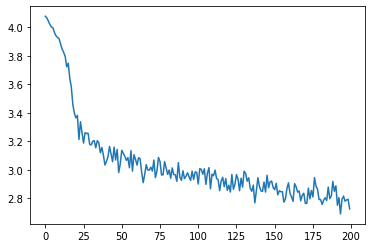

In [43]:
plt.figure()
plt.plot(all_losses)
plt.show()

## Generating New Names

Finally, we'd like to generate new names using our RNN. We've defined helper functions below to help you out. For the homework, please generate German names that start with the letters G, E, and R. (capitalization matters!)

In [44]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    # for reproducibility. DO NOT DELETE
    random.seed(0)
    torch.manual_seed(0)

    with torch.no_grad():  # no need to track gradients at test time
        category_tensor = categoryTensor(category, all_categories)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            _, topi = output.topk(1)
            topi = topi.item()
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            # use the predicted letter as the input for the next prediction
            input = inputTensor(letter)

        return output_name  # feel free to change this if needed

# Generates multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [45]:
samples('German', 'GER')

Garer
Eaner
Rarer
